# PART 1: Final Python Analysis

Step 1: Import the dataset

In [67]:
# Load the cleaned and merged dataset
import pandas as pd
import os
path = r'C:\Users\Jacques\OneDrive\Documents\Data Analytics course\Data Immersion\Section 4\08 April 2025 Instacart Basket Analysis'
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_customers.pkl'))

Step 2: Address data security

In [69]:
# Check for any Personally Identifiable Information (PII)
df.columns  # See all column names

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', '_merge', 'product_name', 'aisle_id',
       'department_id', 'prices', 'product_merge_flag', 'First Name',
       'Surname', 'Gender', 'STATE', 'Age', 'date_joined', 'n_dependants',
       'family_status', 'income'],
      dtype='object')

In [70]:
# Drop columns with personal information
df.drop(columns=['First Name', 'Surname', 'Gender', 'family_status'], inplace=True, errors='ignore')

In [71]:
# Check that the columns are removed
df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', '_merge', 'product_name', 'aisle_id',
       'department_id', 'prices', 'product_merge_flag', 'STATE', 'Age',
       'date_joined', 'n_dependants', 'income'],
      dtype='object')

Step 3: Create regional segmentation

In [73]:
# Change 'STATE' to 'state'
df.rename(columns={'STATE': 'state'}, inplace=True)

In [74]:
# Full State-to-Region Mapping
# Define full mapping of U.S. states to census regions
region_map = {
    # Northeast
    'Connecticut': 'Northeast', 'Maine': 'Northeast', 'Massachusetts': 'Northeast',
    'New Hampshire': 'Northeast', 'Rhode Island': 'Northeast', 'Vermont': 'Northeast',
    'New Jersey': 'Northeast', 'New York': 'Northeast', 'Pennsylvania': 'Northeast',

    # Midwest
    'Illinois': 'Midwest', 'Indiana': 'Midwest', 'Michigan': 'Midwest', 'Ohio': 'Midwest',
    'Wisconsin': 'Midwest', 'Iowa': 'Midwest', 'Kansas': 'Midwest', 'Minnesota': 'Midwest',
    'Missouri': 'Midwest', 'Nebraska': 'Midwest', 'North Dakota': 'Midwest', 'South Dakota': 'Midwest',

    # South
    'Delaware': 'South', 'Florida': 'South', 'Georgia': 'South', 'Maryland': 'South',
    'North Carolina': 'South', 'South Carolina': 'South', 'Virginia': 'South', 'District of Columbia': 'South',
    'West Virginia': 'South', 'Alabama': 'South', 'Kentucky': 'South', 'Mississippi': 'South',
    'Tennessee': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Oklahoma': 'South',
    'Texas': 'South',

    # West
    'Arizona': 'West', 'Colorado': 'West', 'Idaho': 'West', 'Montana': 'West',
    'Nevada': 'West', 'New Mexico': 'West', 'Utah': 'West', 'Wyoming': 'West',
    'Alaska': 'West', 'California': 'West', 'Hawaii': 'West', 'Oregon': 'West',
    'Washington': 'West'
}

# Apply region mapping to the 'state' column
df['region'] = df['state'].map(region_map)

In [75]:
# Check for nulls
df['region'].isnull().sum()

0

Step 4: Analyze spending by region

In [77]:
# Create a spending flag: high spender if price > 10, else low spender
df['spending_flag'] = df['prices'].apply(lambda x: 'High spender' if x > 10 else 'Low spender')

In [78]:
# Check if column was created
df['spending_flag'].value_counts()

spending_flag
Low spender     21888779
High spender    10516080
Name: count, dtype: int64

In [79]:
# Cross-tabulate region with spending_flag
spend_region_ct = pd.crosstab(df['region'], df['spending_flag'], normalize='index')
print(spend_region_ct)

spending_flag  High spender  Low spender
region                                  
Midwest            0.324725     0.675275
Northeast          0.323695     0.676305
South              0.324950     0.675050
West               0.324348     0.675652


Step 5: Exclude low-activity customers

In [81]:
# Flag customers with less than 5 orders
df['low_activity_flag'] = df['order_number'] < 5
df_active = df[df['low_activity_flag'] == False]
df_active.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_customers_active.pkl'))

Step 6: Create a customer profile column

In [83]:
# Rename 'Age' in df before creating df_active
df.rename(columns={'Age': 'age'}, inplace=True)

In [91]:
# Create df_active after the rename
df['low_activity_flag'] = df['order_number'] < 5

# Create independent copy of filtered DataFrame
df_active = df[df['low_activity_flag'] == False].copy()

# Create profile safely
df_active.loc[:, 'profile'] = np.select(conditions, choices, default='Other')

In [93]:
# Import the numpy library
import numpy as np

In [95]:
# Use age, income, department_id, n_dependants to define profiles
conditions = [
    (df_active['age'] < 30) & (df_active['n_dependants'] == 0),
    (df_active['age'] < 40) & (df_active['n_dependants'] > 0),
    (df_active['income'] > 120000),
]
choices = ['Single Young Adult', 'Young Parent', 'Affluent']
df_active['profile'] = np.select(conditions, choices, default='Other')

Step 7: Visualize profile distribution

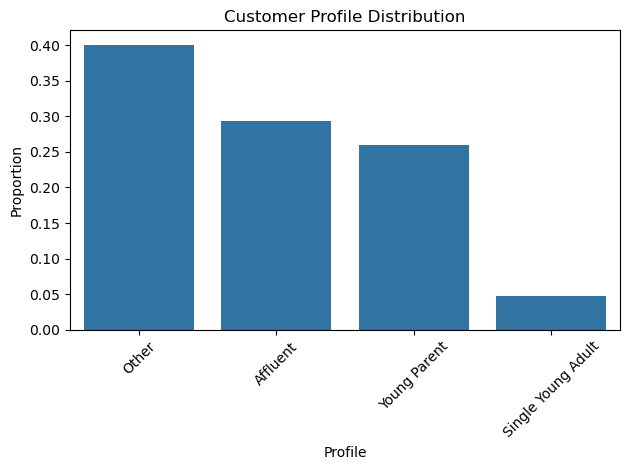

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

profile_dist = df_active['profile'].value_counts(normalize=True)
sns.barplot(x=profile_dist.index, y=profile_dist.values)
plt.title('Customer Profile Distribution')
plt.xlabel('Profile')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profile_distribution.png'))

Step 8: Aggregate stats by profile

In [101]:
# Get the max, mean, min of order_number and prices
agg_profile = df_active.groupby('profile').agg({
    'order_number': ['mean', 'min', 'max'],
    'prices': ['mean', 'min', 'max']
})

Step 9: Profile comparison with region and department

In [104]:
# Crosstabs or groupbys between profile vs region and profile vs department
region_profile_ct = pd.crosstab(df_active['region'], df_active['profile'], normalize='index')
department_profile_ct = pd.crosstab(df_active['department_id'], df_active['profile'], normalize='index')

Step 10: Visualize and export results

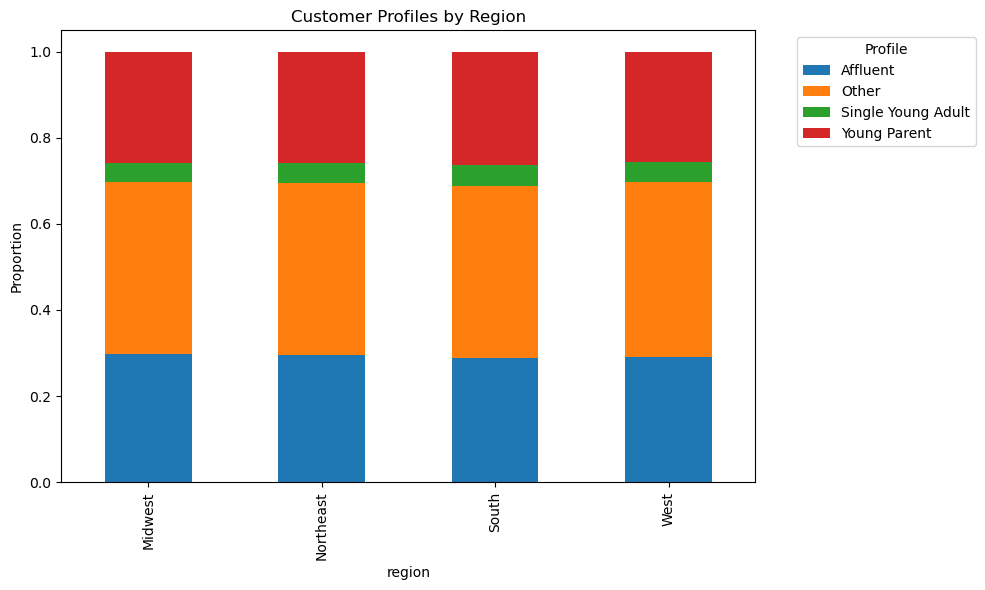

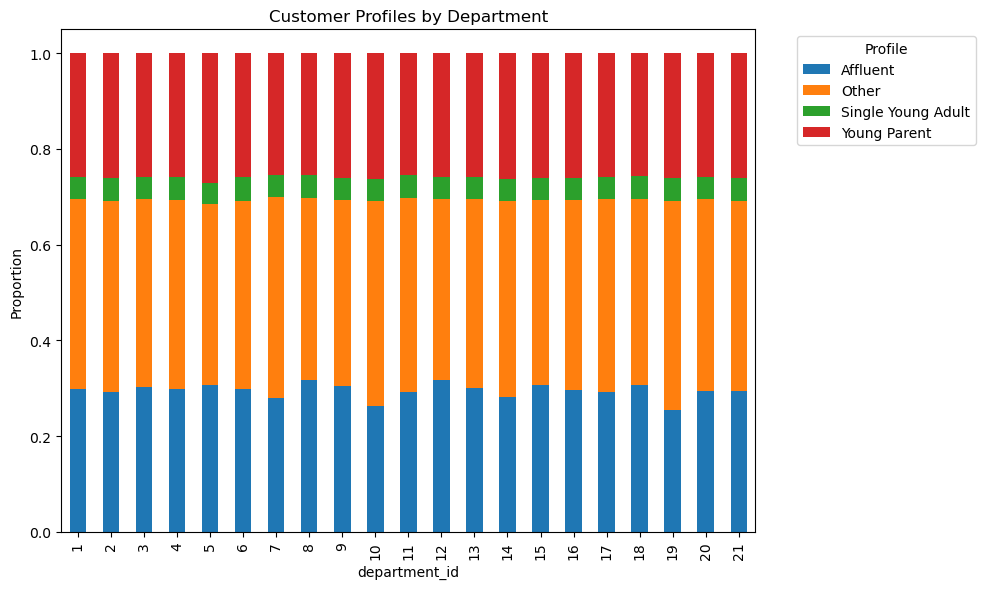

In [109]:
# Profile vs Region
region_profile_ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Customer Profiles by Region')
plt.ylabel('Proportion')

# Move legend to the right
plt.legend(title='Profile', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'region_profile_distribution.png'))
plt.show()


# Profile vs Department
department_profile_ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Customer Profiles by Department')
plt.ylabel('Proportion')

# Move legend to the right
plt.legend(title='Profile', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'department_profile_distribution.png'))
plt.show()

Step 11: Tidy up, save data and notebook

In [112]:
# Clean the notebook, export final dataset
df_active.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_customers_final.pkl'))